# Multivariate Linear Regression - BoomBikes Bike Sharing Assignment

Problem Statement

BoomBikes, a US bike-sharing service, has seen revenue drops due to COVID-19. As the economy recovers, they want to prepare for increased demand. To do so, they need to understand the factors affecting bike-sharing demand in the American market.

They’ve contracted a consulting firm to identify key factors and assess how well these explain bike demand.

Business Goal:

Create a model to predict bike demand, helping BoomBikes adjust strategies and understand demand in new markets.

## Step 1: Importing libraries and packages

In [1]:
import calendar
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Regression libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Suppress warnings
import warnings
warnings.filterwarnings(action = 'ignore')

## Step 2: Data Understanding, Preparation and EDA

In [2]:
# read the dataset
bike_df = pd.read_csv('day.csv');

In [3]:
# Inspect the first 5 rows of the dataframe
bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
# Inspecting the dimensions of the dataframe
bike_df.shape

(730, 16)

In [5]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


- **Dataset consists of 16 columns and 730 rows.**
- **Some columns (e.g., `mnth`, `season`, `weekday`, `weathersit`) are categorical but stored as `int64`, needing conversion during data cleaning.**
- **Columns like `instant`, `dteday`, `casual`, and `registered` are redundant and can be dropped for analysis.**

### Data Quality Checks

### Checking for percentage of null/missing values in the dataset

In [6]:
# row-wise percentage of null values in the dataset in descending order
round(100 * (bike_df.isnull().sum(axis = 1) / len(bike_df)), 2).sort_values(ascending = False)

0      0.0
479    0.0
481    0.0
482    0.0
483    0.0
      ... 
245    0.0
246    0.0
247    0.0
248    0.0
729    0.0
Length: 730, dtype: float64

In [7]:
# column-wise percentage of null values in the dataset in descending order
round(100 * (bike_df.isnull().sum() / len(bike_df)), 2).sort_values(ascending = False)

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

##### There are no null values in the dataset.

### Checking for duplicates in the dataset

In [8]:
# Dropping duplicates
bike_df.drop_duplicates(inplace = True)

In [9]:
# Verifying the shape of the dataframe
bike_df.shape

(730, 16)

##### There are no duplicates in the dataset.

### Data Cleaning and Manipulation

In [10]:
# Checking out the columns present in the dataframe
bike_df.columns.sort_values()

Index(['atemp', 'casual', 'cnt', 'dteday', 'holiday', 'hum', 'instant', 'mnth',
       'registered', 'season', 'temp', 'weathersit', 'weekday', 'windspeed',
       'workingday', 'yr'],
      dtype='object')

### Dropping columns from the dataset

Removing columns with clear justifications:

***1. Eliminated `casual` and `registered` as our focus is on total bike count.***

***2. Dropped `instant` due to redundancy as it contains indexing numbers.***

***3. Excluded `dteday` since `mnth` and `yr` columns provide sufficient date information.***

In [11]:
bike_df.drop(['casual', 'dteday', 'instant', 'registered'], axis = 1, inplace = True)

In [12]:
bike_df.shape

(730, 12)

### Data Conversion

**Converting `season` into a categorical variable as per data dictionary**

In [13]:
# Check the different values for seasons in descending order
bike_df['season'].value_counts(ascending = False)

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [14]:
# Replace the numbers to different class values of season as per data dictionary
bike_df['season'].replace({ 1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter' }, inplace = True)

In [15]:
# Confirm using the above values to ensure successful conversion.
bike_df['season'].value_counts(ascending = False)

Fall      188
Summer    184
Spring    180
Winter    178
Name: season, dtype: int64

**Converting `mnth` values (1, 2, ... , 11, 12) into a categorical variable like January, February, ... , November, December**

In [16]:
# Check the different values for months in descending order
bike_df['mnth'].value_counts(ascending = False)

1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: mnth, dtype: int64

In [17]:
# Replace the numbers to different class values of the month
bike_df['mnth'] = bike_df['mnth'].apply(lambda x: calendar.month_name[x])

In [18]:
# Confirm using the above values to ensure successful conversion.
bike_df['mnth'].value_counts(ascending = False)

January      62
March        62
May          62
July         62
August       62
October      62
December     62
April        60
June         60
September    60
November     60
February     56
Name: mnth, dtype: int64

**Converting `weekday` values (0, 1, ... , 5, 6) into a categorical variable like Monday, Tuesday, ... , Saturday, Sunday**

In [19]:
# Check the different values for weekday in descending order
bike_df['weekday'].value_counts(ascending = False)

6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64

In [20]:
# Replace the numbers to different class values of weekday
bike_df['weekday'] = bike_df['weekday'].apply(lambda x: calendar.day_name[x])

In [21]:
# Confirm using the above values to ensure successful conversion.
bike_df['weekday'].value_counts(ascending = False)

Sunday       105
Monday       105
Tuesday      105
Wednesday    104
Friday       104
Saturday     104
Thursday     103
Name: weekday, dtype: int64

**Converting `weathersit` into a categorical variable as per data dictionary**

In [22]:
# Check the different values for weather in descending order
bike_df['weathersit'].value_counts(ascending = False)

1    463
2    246
3     21
Name: weathersit, dtype: int64

The weathersit column has three entries, but the data dictionary defines four types with multiple labels for a single value. To clarify, we map the values as follows:

1. Good: Clear, Few clouds, Partly cloudy
2. Moderate: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3. Bad: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4. Severe: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

We'll standardize these values from 1 to 4 for consistent cleaning across the dataset.

In [23]:
bike_df['weathersit'].replace({ 1: 'Good', 2: 'Moderate', 3: 'Bad', 4: 'Severe' }, inplace = True)

In [24]:
# Confirm using the above values to ensure successful conversion.
bike_df['weathersit'].value_counts(ascending = False)

Good        463
Moderate    246
Bad          21
Name: weathersit, dtype: int64

In [25]:
# Inspecting the values in the dataframe after data conversion
bike_df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,0,January,0,Sunday,0,Moderate,14.110847,18.18125,80.5833,10.749882,985
1,Spring,0,January,0,Monday,0,Moderate,14.902598,17.68695,69.6087,16.652113,801
2,Spring,0,January,0,Tuesday,1,Good,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,0,January,0,Wednesday,1,Good,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,0,January,0,Thursday,1,Good,9.305237,11.46350,43.6957,12.522300,1600


### Exploratory Data Analysis (EDA)

### Univariate Analysis

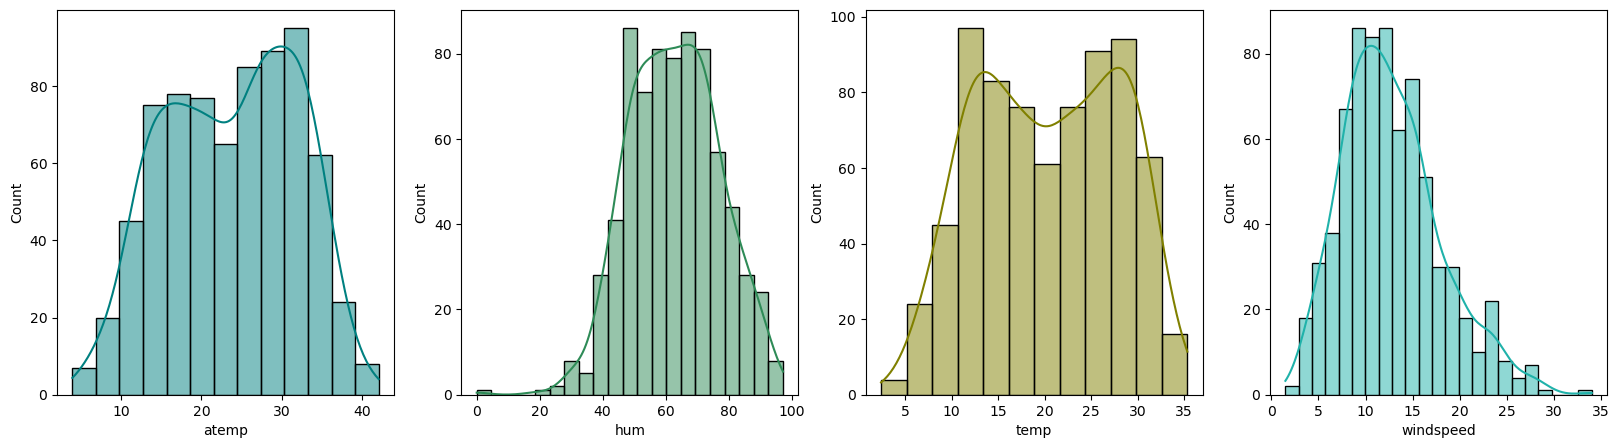

In [26]:
# Analysing the continuous (numerical) variables

continuous_config = {
    'atemp': { 'color': 'teal' },
    'hum': { 'color': 'seagreen' },
    'temp': { 'color': 'olive' },
    'windspeed': { 'color': 'lightseagreen' }
}

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 5))

for i, (cont, config) in enumerate(continuous_config.items()):
    sns.histplot(data = bike_df, x = cont, ax = ax[i], color = config['color'], kde = True)

plt.show()

- **Average Temperature (`temp`)**: 20°C  
- **Average Feeling Temperature (`atemp`)**: 24°C  
- **Average Humidity (`hum`)**: 62  
- **Average Windspeed (`windspeed`)**: 12

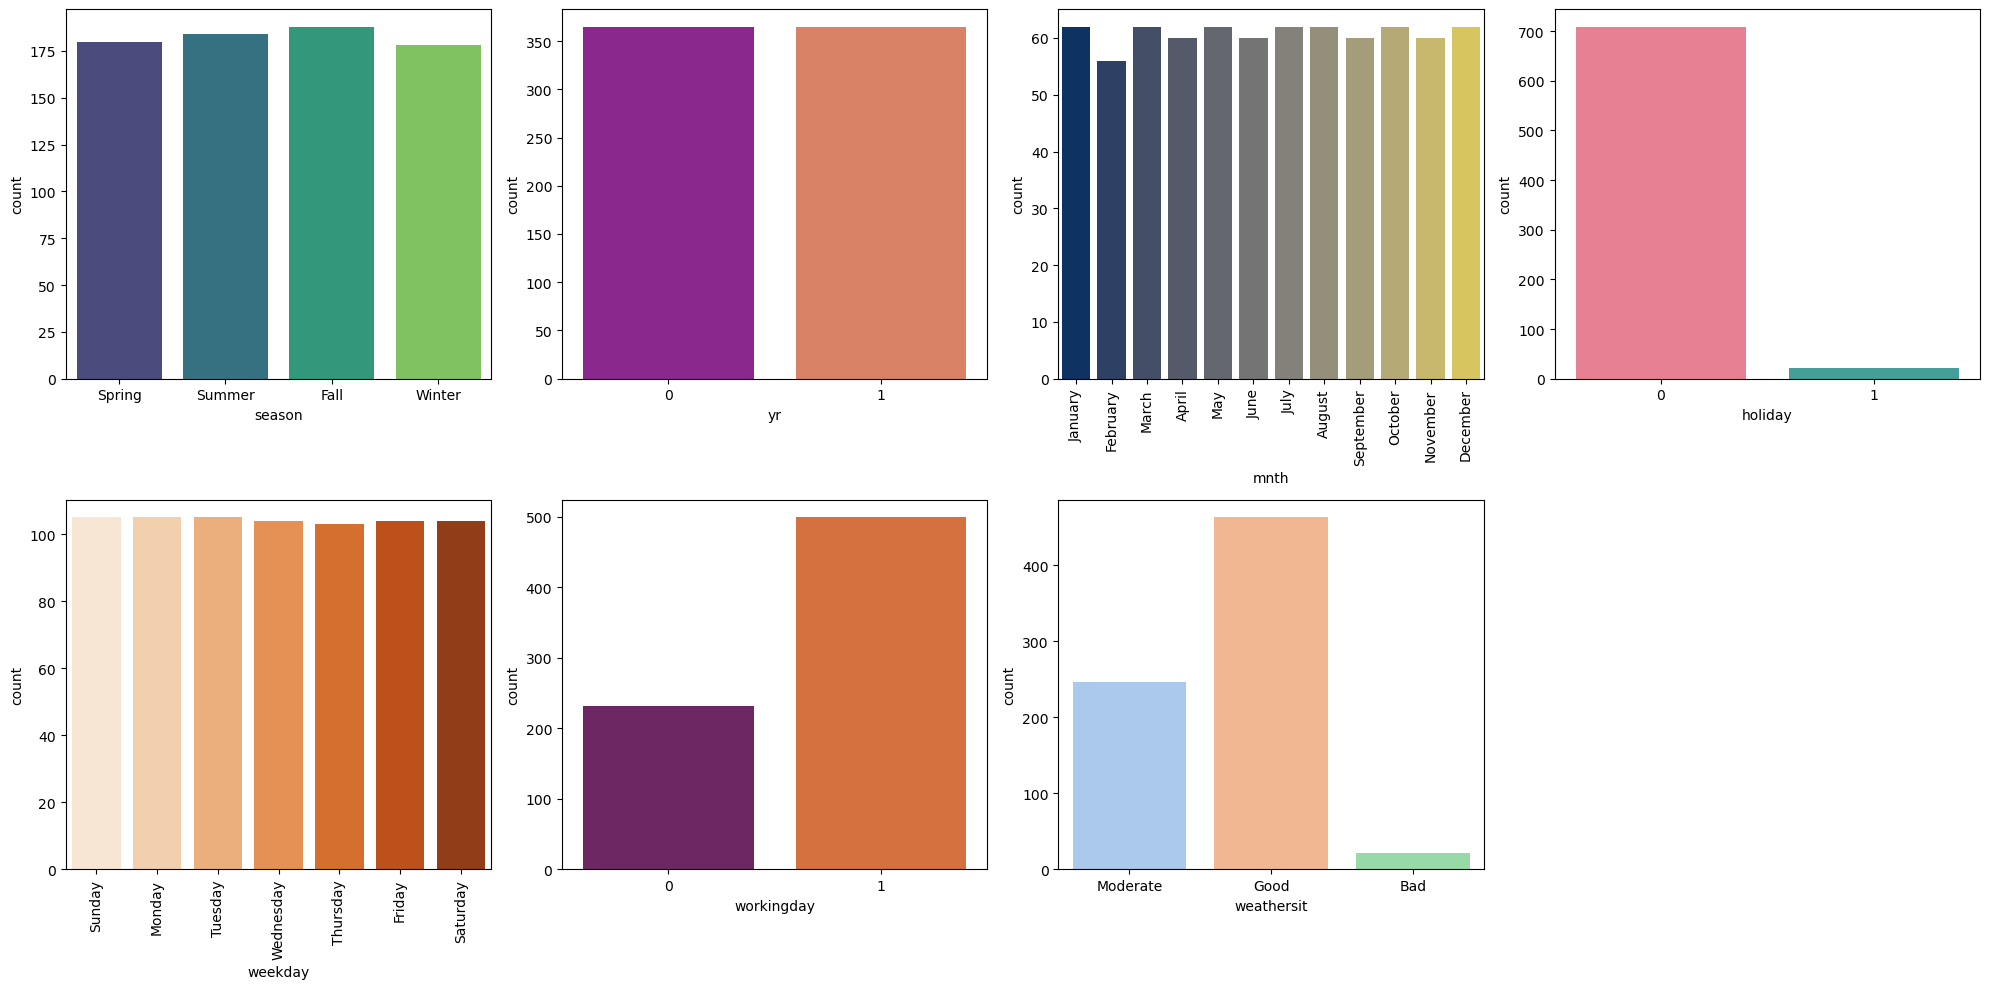

In [27]:
# Analysing the categorical variables

categorical_config = {
    'season': { 'rotation': 0, 'palette': 'viridis' },
    'yr': { 'rotation': 0, 'palette': 'plasma' },
    'mnth': { 'rotation': 90, 'palette': 'cividis' },
    'holiday': { 'rotation': 0, 'palette': 'husl' },
    'weekday': { 'rotation': 90, 'palette': 'Oranges' },
    'workingday': { 'rotation': 0, 'palette': 'inferno' },
    'weathersit': { 'rotation': 0, 'palette': 'pastel' }
}

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 10))

for i, (cat, config) in enumerate(categorical_config.items()):
    sns.countplot(data = bike_df, x = cat, palette = config['palette'], ax = ax[i // 4, i % 4])
    ax[i // 4, i % 4].set_xticklabels(ax[i // 4, i % 4].get_xticklabels(), rotation = config['rotation'])

# Hide the last column
ax[1, 3].axis('off')

plt.tight_layout()
plt.show()

- **More bike rentals** occur in favorable weather conditions.  
- **Higher demand** for bike rentals on working days and non-holidays.  
- **Minimal variation** observed in other categorical variables across categories.

### Bivariate Analysis

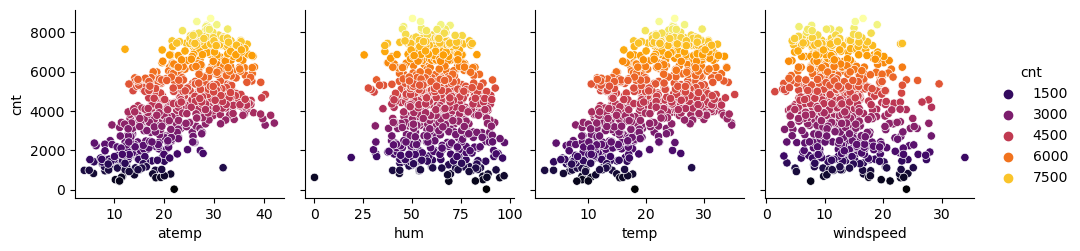

In [28]:
# Draw pairplot for continuous independent numeric variables against a dependent variable `cnt`
sns.pairplot(data = bike_df, x_vars = list(continuous_config.keys()), y_vars = ['cnt'], hue = 'cnt', palette = 'inferno')
plt.show()

In [29]:
# Correlation between numerical variables
bike_df[list(continuous_config.keys()) + ['cnt']].corr(numeric_only = True)

,atemp,hum,temp,windspeed,cnt
atemp,1.000000,0.141512,0.991696,-0.183876,0.630685
hum,0.141512,1.000000,0.128565,-0.248506,-0.098543
temp,0.991696,0.128565,1.000000,-0.158186,0.627044
windspeed,-0.183876,-0.248506,-0.158186,1.000000,-0.235132
cnt,0.630685,-0.098543,0.627044,-0.235132,1.000000


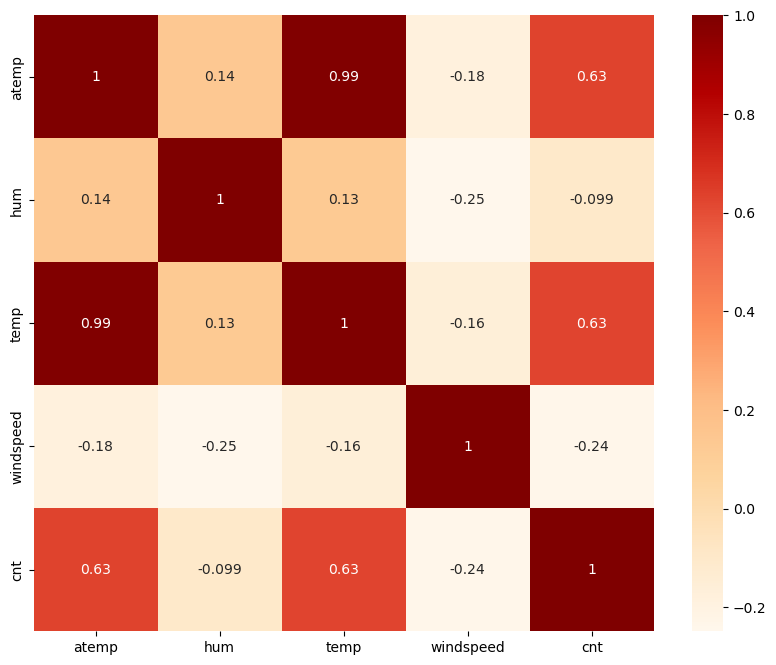

In [30]:
plt.figure(figsize = (10, 8))
corr_df = bike_df[list(continuous_config.keys()) + ['cnt']].corr(numeric_only = True)
sns.heatmap(data = corr_df, annot = True, cmap = 'OrRd')
plt.show()

- **`atemp` and `temp`** are strongly correlated with **`cnt`**, suggesting favorable temperatures boost bike rentals.  
- **`atemp` and `temp`** show strong correlation, indicating redundancy; consider **feature elimination** to remove one.  
- **`windspeed` and `hum`** are negatively correlated with bike rentals, indicating **unfavorable biking conditions**.

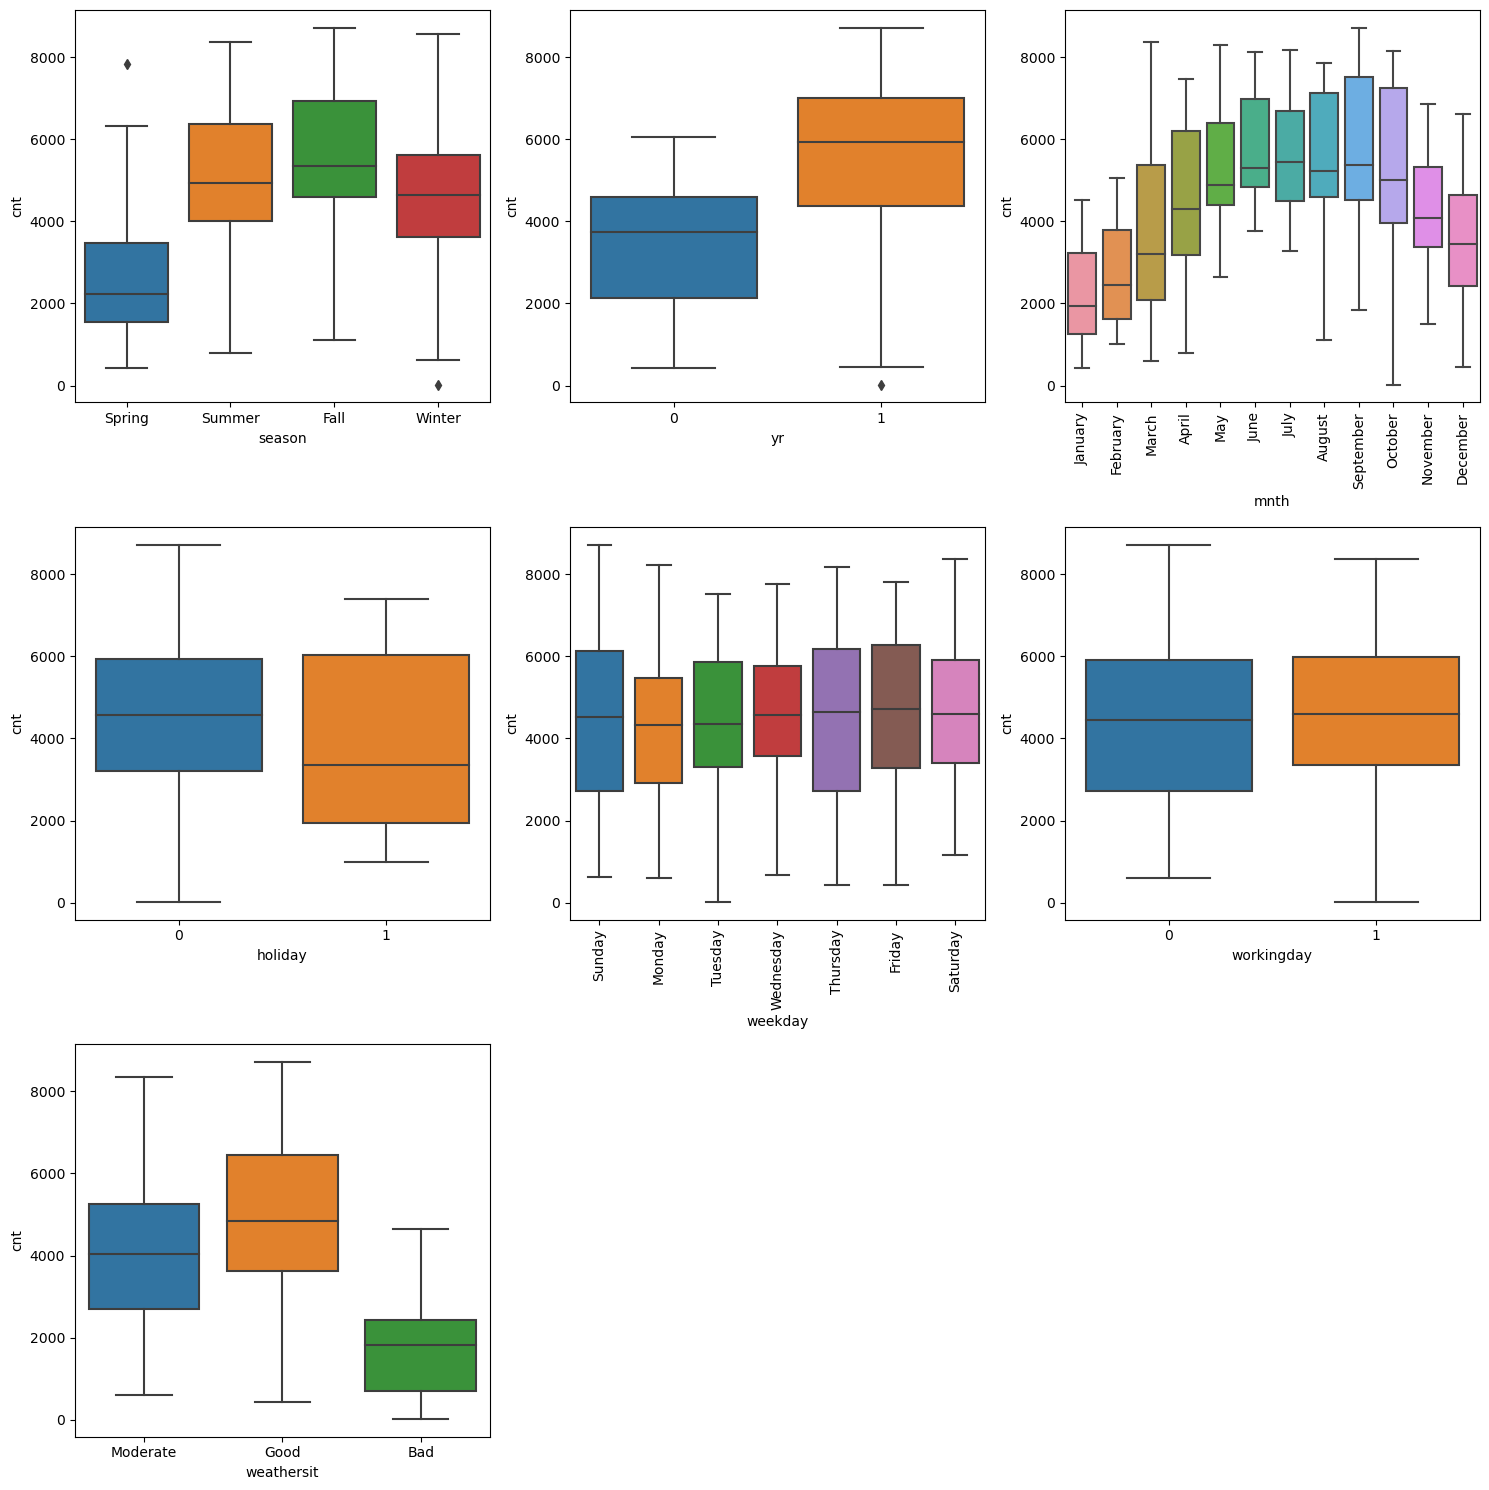

In [31]:
# Draw boxplot for categorical variables against a dependent variable `cnt`
plt.figure(figsize = (15, 15))
for i, (cat, config) in enumerate(categorical_config.items()):
    plt.subplot(3, 3, i+1)
    sns.boxplot(data = bike_df, x = cat, y = 'cnt')
    plt.xticks(rotation = config['rotation'])

plt.tight_layout()    
plt.show()

- **Fall season** saw slightly more bike rentals than **Summer**.  
- **2019** had higher bike rentals than **2018**.  
- Peak rentals occurred **July-September**.  
- More bikes were rented on **non-holiday and working days**.  
- The highest rentals were during **good weather conditions**.

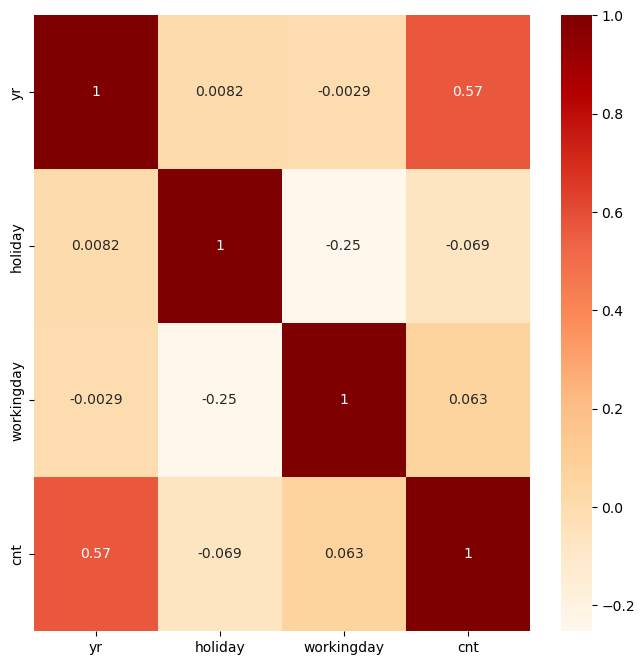

In [32]:
# Verifying the correlation
plt.figure(figsize = (8, 8))
corr_df = bike_df[list(categorical_config.keys()) + ['cnt']].corr(numeric_only = True)
sns.heatmap(data = corr_df, annot = True, cmap = 'OrRd')
plt.show()

- ***`yr` is having the best positive correlation among all categorical variables.***

### Multivariate Analysis

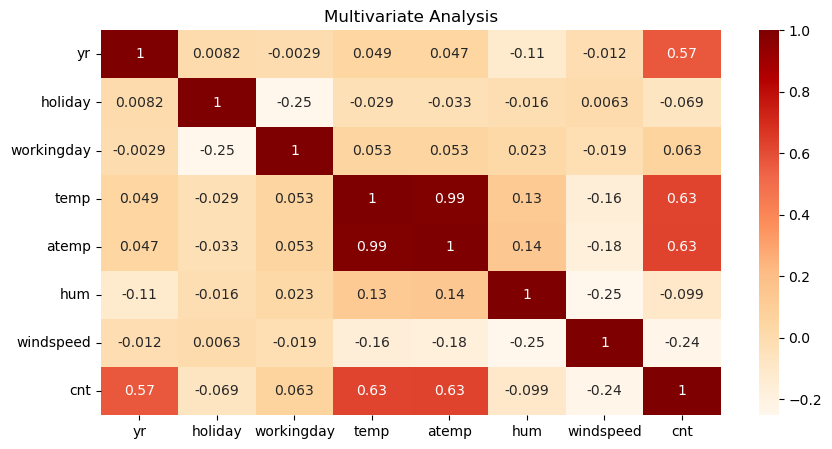

In [33]:
plt.figure(figsize = (10, 5))
sns.heatmap(bike_df.corr(numeric_only = True), annot = True, cmap = 'OrRd')

plt.title("Multivariate Analysis")
plt.show()

- **`cnt`** negatively correlates with **`holiday`**, **`hum`**, and **`windspeed`**.  
- **`cnt`** positively correlates with **`yr`**, **`workingday`**, **`temp`**, and **`atemp`**.  
- The high correlation between **`temp`** and **`atemp`** confirms they are nearly identical.

<Figure size 3000x2000 with 0 Axes>

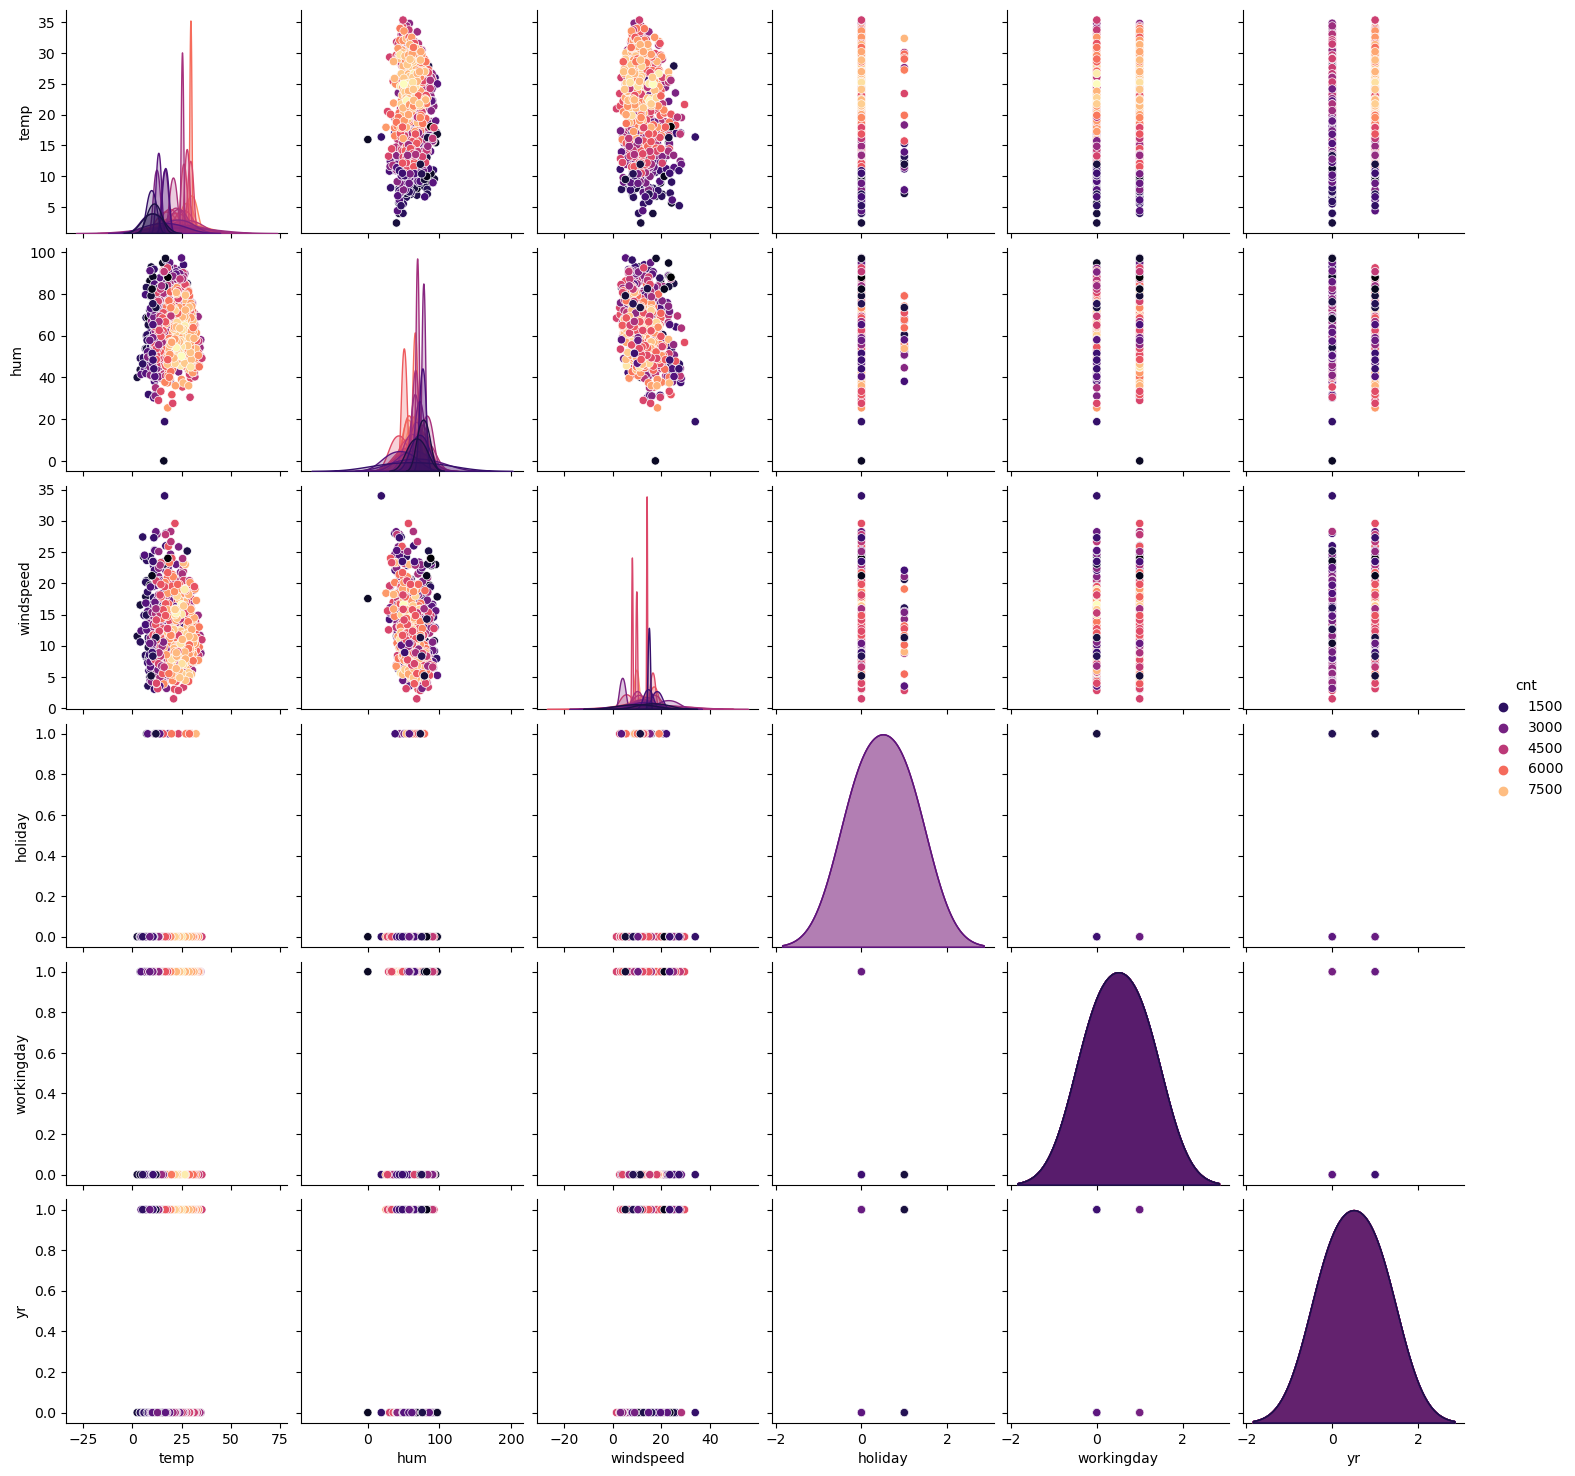

In [34]:
# Viusalize the above correlation
plt.figure(figsize = (30, 20))
sns.pairplot(data = bike_df, vars = ['temp', 'hum', 'windspeed', 'holiday', 'workingday', 'yr'], hue = 'cnt', palette = 'magma')
plt.show()

### Data Preparation

### Creation of Dummy Variables (One Hot Encoding)

##### Dummy variables are only required if the categorical values are more than 2 unique values. They dummy variables are always number of unique values  - 1. We can drop any column, but generally, we drop the first column.

In [35]:
bike_df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

In [36]:
cat_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
bike_df[cat_cols].nunique()

season         4
yr             2
mnth          12
holiday        2
weekday        7
workingday     2
weathersit     3
dtype: int64

- ***Only the categorical variables - `season`, `mnth`, `weekday`, and `weathersit`, among those mentioned, have more than 2 unique values. Dummy variables will be created exclusively for these columns.***

In [37]:
bike_df = pd.get_dummies(data = bike_df, columns = ['season', 'mnth', 'weekday', 'weathersit'], drop_first = True, prefix = '', prefix_sep = '')

- ***Dropping the first column in each category (`season`, `mnth`, `weekday`, `weathersit`) reduces the number of dummy variables to (n - 1) for explaining n categories.***

In [38]:
# Inspecting the new bike dataframe
bike_df.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,Spring,Summer,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Good,Moderate
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,0,0,1,0,1,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,0,0,1,1,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,1,0,0,1,0


In [39]:
# Inspecting the columns in dataframe
bike_df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'Spring', 'Summer', 'Winter', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'September', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'Good', 'Moderate'],
      dtype='object')

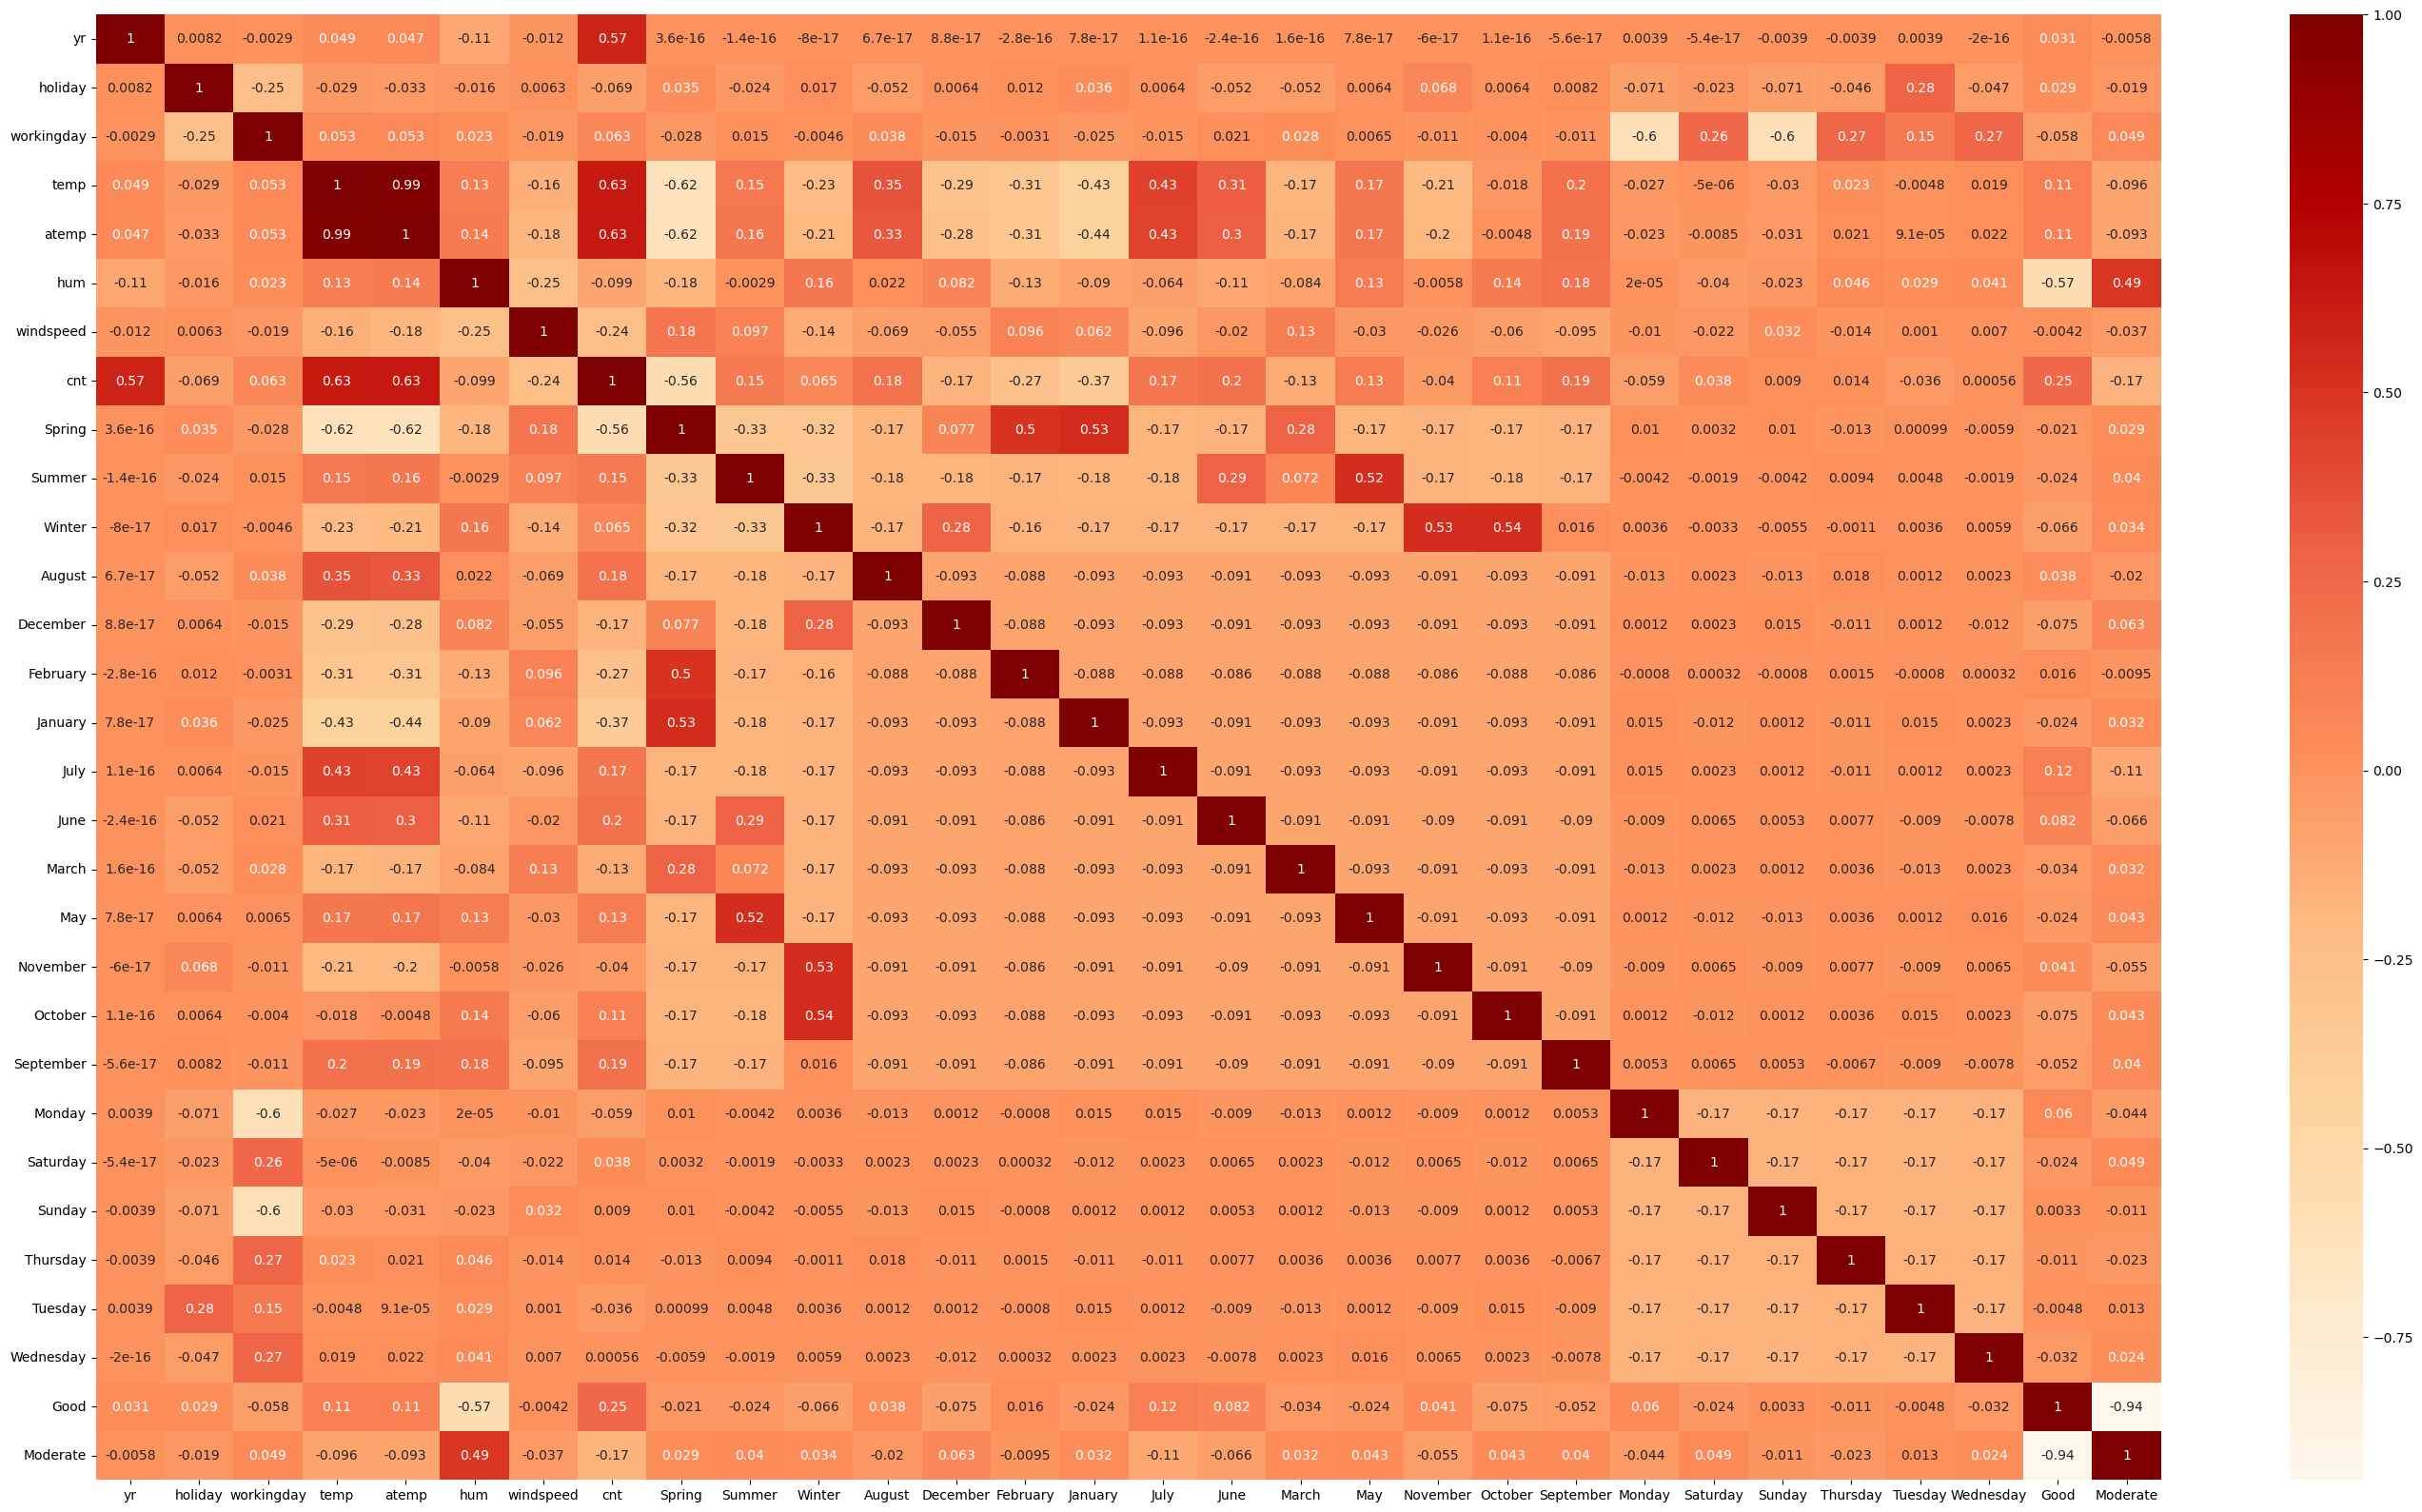

In [40]:
# Checking how are all these related to the dependent variable via correlation
plt.figure(figsize = (35, 20))
corr_df = bike_df[list(bike_df.columns)].corr(numeric_only = True)
sns.heatmap(data = corr_df, annot = True, cmap = 'OrRd')
plt.show()

In [41]:
bike_df.shape

(730, 30)

##### Bike dataframe used for model building will have 730 rows and 30 columns

## Step 3: Model Building and Evaluation

In [42]:
# Getting the feature variables in X and dependent variable `cnt` in y
X = bike_df.drop('cnt', axis = 1)
y = bike_df['cnt']

### Splitting the dataset into training and test set

In [43]:
# Splitting the data into a 70% training set and a 30% test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [44]:
# Checking shape and size for train and test set
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(511, 29)
(511,)
(219, 29)
(219,)


In [45]:
# Inspect the head of the training set
X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,Spring,Summer,Winter,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Good,Moderate
653,1,0,1,19.201653,23.0423,55.8333,12.208807,0,0,1,...,1,0,0,0,0,0,0,1,1,0
576,1,0,1,29.246653,33.1448,70.4167,11.083475,0,0,0,...,0,0,0,0,0,0,0,1,1,0
426,1,0,0,16.980847,20.6746,62.1250,10.792293,1,0,0,...,0,0,0,0,1,0,0,0,0,1
728,1,0,0,10.489153,11.5850,48.3333,23.500518,1,0,0,...,0,0,1,0,0,0,0,0,1,0
482,1,0,0,15.443347,18.8752,48.9583,8.708325,0,1,0,...,0,0,0,0,1,0,0,0,0,1


### Feature Scaling using StandardScaler

StandardScaler is a preprocessing technique that transforms the features of a dataset to have a mean of 0 and a standard deviation of 1, ensuring consistent scales for machine learning algorithms sensitive to feature magnitudes.

In [46]:
# Use StandardScaler to scale values
scaler = StandardScaler()

# Fit and transform training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)

# Only Transform Test set
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns, index = X_test.index)

In [47]:
# Inspect the training set after scaling
X_train_scaled.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,Spring,Summer,Winter,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Good,Moderate
653,0.98254,-0.161569,0.690564,-0.121991,-0.056605,-0.514975,-0.118309,-0.566051,-0.572078,1.738857,...,3.257858,-0.295354,-0.408248,-0.381759,-0.427633,-0.434019,-0.421212,2.552392,0.772577,-0.724826
576,0.98254,-0.161569,0.690564,1.232298,1.194457,0.517177,-0.331370,-0.566051,-0.572078,-0.575091,...,-0.306950,-0.295354,-0.408248,-0.381759,-0.427633,-0.434019,-0.421212,2.552392,0.772577,-0.724826
426,0.98254,-0.161569,-1.448092,-0.421405,-0.349813,-0.069675,-0.386500,1.766626,-0.572078,-0.575091,...,-0.306950,-0.295354,-0.408248,-0.381759,2.338451,-0.434019,-0.421212,-0.391789,-1.294370,1.379641
728,0.98254,-0.161569,-1.448092,-1.296629,-1.475441,-1.045794,2.019569,1.766626,-0.572078,-0.575091,...,-0.306950,-0.295354,2.449490,-0.381759,-0.427633,-0.434019,-0.421212,-0.391789,0.772577,-0.724826
482,0.98254,-0.161569,-1.448092,-0.628694,-0.572645,-1.001559,-0.781062,-0.566051,1.748015,-0.575091,...,-0.306950,-0.295354,-0.408248,-0.381759,2.338451,-0.434019,-0.421212,-0.391789,-1.294370,1.379641


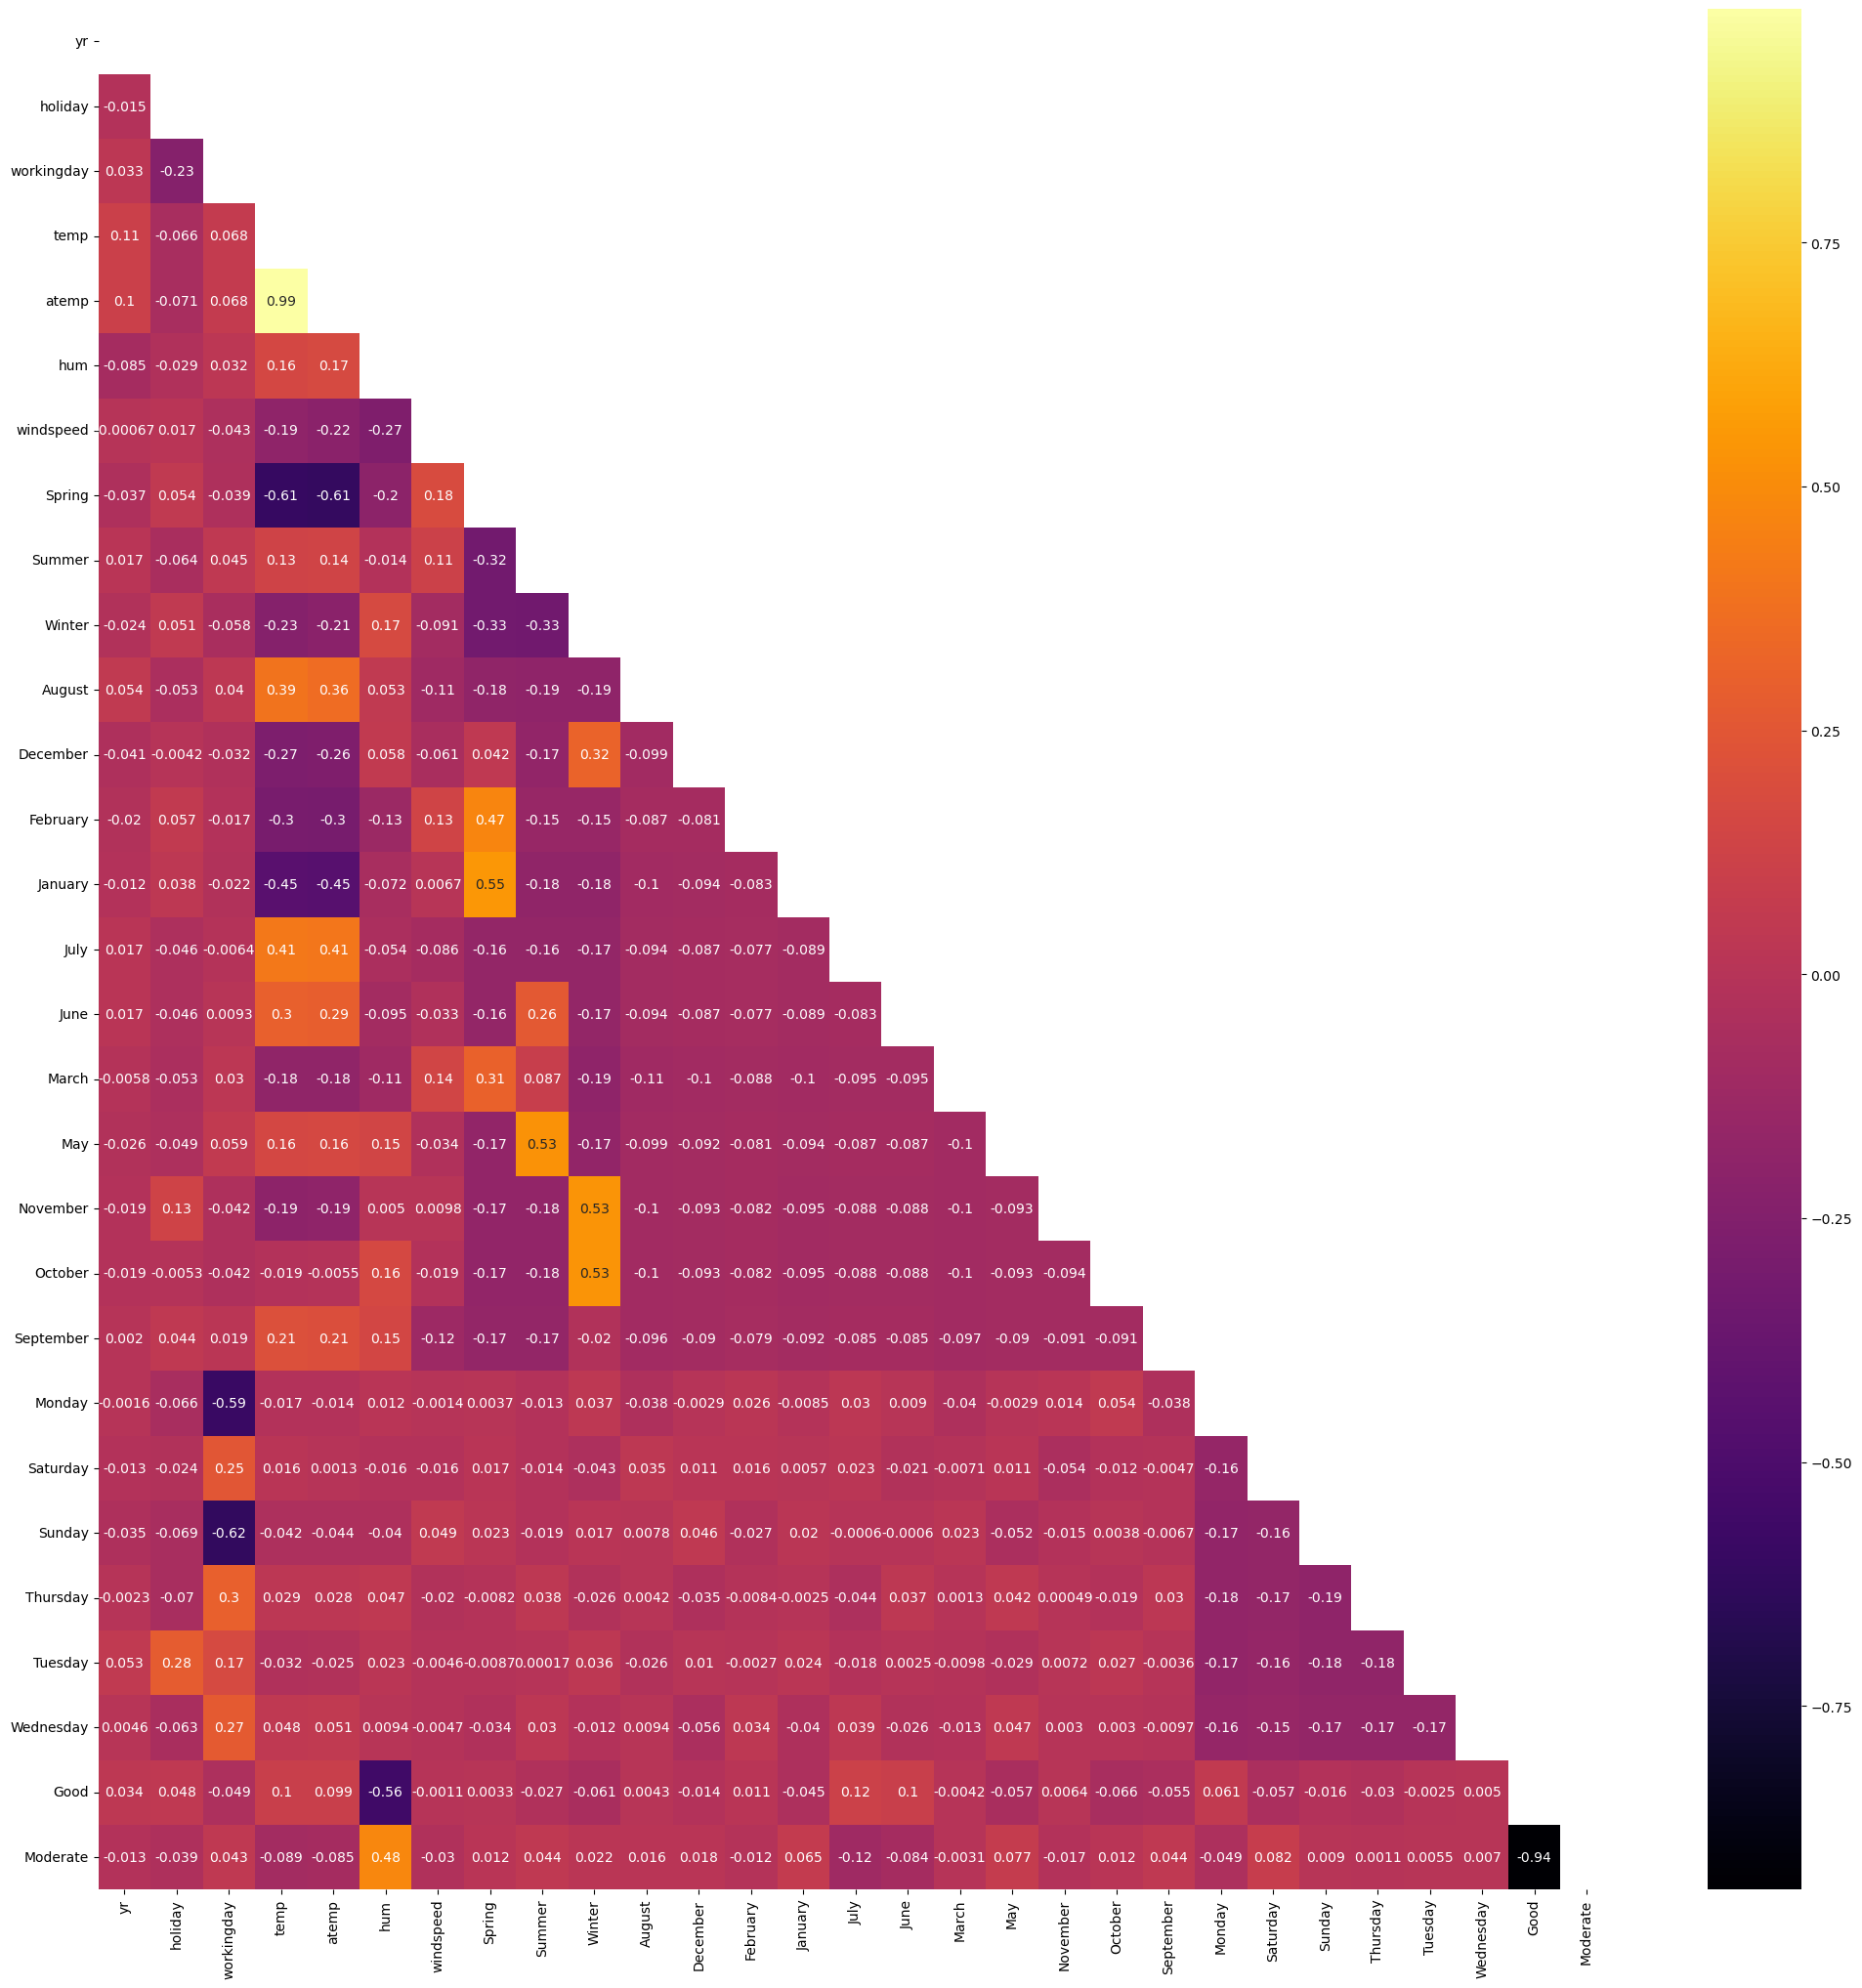

In [48]:
# Inspecting the correlation in the training dataframe
plt.figure(figsize = (25, 25))
matrix = np.triu(X_train_scaled.corr())
sns.heatmap(X_train_scaled.corr(), annot = True, cmap = "inferno", mask = matrix)
plt.show()

- ***`November` and `October` correlate strongly with `Winter`.***
- ***`May` has a high correlation with `Summer`.***
- ***`hum` is positively correlated with `Moderate`.***

### Selecting Features using Recursive Feature Elimination (RFE) approach

RFE, or Recursive Feature Elimination, is a feature selection technique in machine learning. It works by recursively removing the least important features based on model performance, helping to identify the most relevant features for optimal model accuracy and efficiency.

*****Selecting top 15 features generated using RFE*****

In [49]:
# Create and train the model with RFE
lm = LinearRegression()

rfe = RFE(lm, n_features_to_select = 15)

rfe = rfe.fit(X_train_scaled, y_train)

In [50]:
rfe.support_

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False, False, False, False,  True, False, False, False,
       False, False,  True,  True, False,  True, False, False, False,
        True,  True])

In [51]:
# List of feature variables and their respective selection status and ranks
list(zip(X_train_scaled.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 5),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Spring', True, 1),
 ('Summer', True, 1),
 ('Winter', True, 1),
 ('August', False, 7),
 ('December', False, 13),
 ('February', False, 11),
 ('January', False, 6),
 ('July', True, 1),
 ('June', False, 10),
 ('March', False, 2),
 ('May', False, 4),
 ('November', False, 3),
 ('October', False, 15),
 ('September', True, 1),
 ('Monday', True, 1),
 ('Saturday', False, 8),
 ('Sunday', True, 1),
 ('Thursday', False, 9),
 ('Tuesday', False, 12),
 ('Wednesday', False, 14),
 ('Good', True, 1),
 ('Moderate', True, 1)]

In [52]:
# Get the columns which are selected using RFE approach
selected_features = X_train_scaled.columns[rfe.support_]

In [53]:
# Verifying column names which are selected
selected_features

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'Spring',
       'Summer', 'Winter', 'July', 'September', 'Monday', 'Sunday', 'Good',
       'Moderate'],
      dtype='object')

In [54]:
# Get the columns which are rejected using RFE approach
rejected_features = X_train_scaled.columns[~rfe.support_]

In [55]:
# Verifying column names which are rejected
rejected_features

Index(['atemp', 'August', 'December', 'February', 'January', 'June', 'March',
       'May', 'November', 'October', 'Saturday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

### Common Utility Functions

Here are three Python utility methods designed for reuse in modeling, VIF calculation, and adjusted R2 score calculation.

In [56]:
def adjusted_r2_score(y_true, y_pred, n_features):
    """
    Calculate the adjusted R-squared (R2_adj) score.

    The adjusted R2 score is a modified version of the traditional R-squared that takes into account the number of
    predictors (independent variables) in a regression model. It penalizes the inclusion of unnecessary predictors
    that do not significantly contribute to explaining the variance.

    Parameters:
    - y_true (array-like): True target values.
    - y_pred (array-like): Predicted values.
    - n_features (int): Number of features (independent variables) in the model.

    Returns:
    - float: Adjusted R-squared score.
    """
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - n_features - 1))
    return adjusted_r2

In [57]:
def calculate_VIF(X_train):
    """
    Calculate Variance Inflation Factor (VIF) for features in the training set.

    VIF measures the extent to which the variance of an independent variable is inflated by the existence of other 
    independent variables in the model. High VIF values indicate strong correlation between variables.

    Parameters:
    - X_train (pd.DataFrame): Input features in the training set.

    Returns:
    - pd.DataFrame: DataFrame containing Features and their corresponding VIF values.
    """
    vif = pd.DataFrame()
    vif["Features"] = X_train.columns
    vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
    
    vif['VIF'] = round(vif['VIF'], 2)
    return vif.sort_values(by = 'VIF', ascending = False)

In [58]:
def generate_model_with_summary(X_train, y_train):
    """
    Generate and fit an Ordinary Least Squares (OLS) model using statsmodels,
    print the model summary, and return a dictionary with the fitted model and
    the features with an added constant term.

    Parameters:
    - X_train (DataFrame): Features for training.
    - y_train (Series): Target variable for training.

    Returns:
    dict: A dictionary containing the fitted OLS model ('model') and the features
          with added constant term ('X_train_sm').
    """
    X_train_sm = sm.add_constant(X_train)
    lm = sm.OLS(y_train, X_train_sm).fit()
    print(lm.summary())
    return { 'model' : lm, 'X_train_sm' : X_train_sm }

### Manual Feature Elimination using `statsmodels` and `VIF`

Steps to be taken while performing Manual Feature Elimination:

- **Multicollinearity:** Address high correlation between features.
- **Overfitting:** Prevent the model from fitting noise in the data.
- **Interpretability:** Simplify the model for better understanding.
- **Model Performance:** Improve computational efficiency and generalization.
- **Data Quality:** Eliminate irrelevant or redundant features for cleaner data.

###### Manual feature elimination requires identifying features with p-values exceeding 0.05, rendering their coefficients statistically insignificant, and having VIF values surpassing 5.

### Model 1

Creating our first model using the selected features from RFE approach

In [59]:
X_train_rfe_1 = X_train_scaled[selected_features]

In [60]:
generate_model_with_summary(X_train_rfe_1, y_train)
calculate_VIF(X_train_rfe_1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     193.8
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          1.03e-190
Time:                        13:35:39   Log-Likelihood:                -4119.6
No. Observations:                 511   AIC:                             8269.
Df Residuals:                     496   BIC:                             8333.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4491.3033     34.450    130.370      0.0

,Features,VIF
1,holiday,inf
2,workingday,inf
11,Monday,inf
12,Sunday,inf
13,Good,10.26
14,Moderate,8.88
6,Spring,5.02
3,temp,3.62
8,Winter,3.50
7,Summer,2.62


### Model 2

- ***Excluding `holiday` due to its elevated p-value of 0.127 and a high VIF approaching `inf`, indicating potential multicollinearity.***

In [61]:
X_train_rfe_2 = X_train_rfe_1.drop(['holiday'], axis = 1)

In [62]:
generate_model_with_summary(X_train_rfe_2, y_train)
calculate_VIF(X_train_rfe_2)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.2
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          7.31e-192
Time:                        13:35:39   Log-Likelihood:                -4116.8
No. Observations:                 511   AIC:                             8264.
Df Residuals:                     496   BIC:                             8327.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4491.3033     34.266    131.072      0.0

,Features,VIF
12,Good,10.26
1,workingday,9.08
13,Moderate,8.88
11,Sunday,6.06
10,Monday,5.74
5,Spring,5.02
2,temp,3.62
7,Winter,3.50
6,Summer,2.62
3,hum,1.91


### Model 3

- ***Removing `Good` because it has very high VIF of 10.26***

In [63]:
X_train_rfe_3 = X_train_rfe_2.drop(['Good'], axis = 1)

In [64]:
generate_model_with_summary(X_train_rfe_3, y_train)
calculate_VIF(X_train_rfe_3)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     174.0
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          2.06e-175
Time:                        13:35:39   Log-Likelihood:                -4158.7
No. Observations:                 511   AIC:                             8345.
Df Residuals:                     497   BIC:                             8405.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4491.3033     37.157    120.874      0.0

,Features,VIF
1,workingday,9.06
11,Sunday,6.05
10,Monday,5.74
5,Spring,5.00
2,temp,3.56
7,Winter,3.49
6,Summer,2.62
3,hum,1.61
8,July,1.49
12,Moderate,1.40


### Model 4

- ***Remove season (`Spring`) because it has a high p-value of 0.063***

In [65]:
X_train_rfe_4 = X_train_rfe_3.drop(['Spring'], axis = 1)

In [66]:
generate_model_with_summary(X_train_rfe_4, y_train)
calculate_VIF(X_train_rfe_4)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     187.2
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          8.22e-176
Time:                        13:35:39   Log-Likelihood:                -4160.5
No. Observations:                 511   AIC:                             8347.
Df Residuals:                     498   BIC:                             8402.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4491.3033     37.249    120.576      0.0

,Features,VIF
1,workingday,9.05
10,Sunday,6.04
9,Monday,5.73
3,hum,1.59
2,temp,1.58
7,July,1.43
11,Moderate,1.39
5,Summer,1.33
6,Winter,1.29
8,September,1.19


### Model 5

- ***Remove (`Monday`) because it has a high p-value of 0.052 and high VIF value of 5.73***

In [67]:
X_train_rfe_5 = X_train_rfe_4.drop(['Monday'], axis = 1)

In [68]:
generate_model_with_summary(X_train_rfe_5, y_train)
calculate_VIF(X_train_rfe_5)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     202.8
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          3.68e-176
Time:                        13:35:39   Log-Likelihood:                -4162.4
No. Observations:                 511   AIC:                             8349.
Df Residuals:                     499   BIC:                             8400.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4491.3033     37.353    120.241      0.0

,Features,VIF
1,workingday,1.64
9,Sunday,1.63
3,hum,1.59
2,temp,1.58
7,July,1.43
10,Moderate,1.39
5,Summer,1.33
6,Winter,1.29
8,September,1.19
4,windspeed,1.14


#### The model appears favorable, with a low Prob (F-statistic) of 3.68e-176, minimal p-values, VIF below 5 for all features, and $R^2$ and Adjusted $R^2$ values of 0.817 and 0.813. However, further refinement is planned to explore potential feature reduction without significant impact on $R^2$.

### Model 6

- ***Remove weathersit (`Moderate`) because it has a marginal p-value of 0.032***

In [69]:
X_train_rfe_6 = X_train_rfe_5.drop(['Moderate'], axis = 1)

In [70]:
generate_model_with_summary(X_train_rfe_6, y_train)
calculate_VIF(X_train_rfe_6)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     221.0
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          2.40e-176
Time:                        13:35:39   Log-Likelihood:                -4164.8
No. Observations:                 511   AIC:                             8352.
Df Residuals:                     500   BIC:                             8398.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4491.3033     37.488    119.807      0.0

,Features,VIF
1,workingday,1.63
9,Sunday,1.63
2,temp,1.53
7,July,1.43
5,Summer,1.33
6,Winter,1.27
8,September,1.19
3,hum,1.17
4,windspeed,1.13
0,yr,1.03


#### The model remains robust with minimal $R^2$ decrease; let's refine it by removing another feature and observe.

### Model 7

- ***Remove Month (`July`) because it has a marginal p-value of 0.007***

In [71]:
X_train_rfe_7 = X_train_rfe_6.drop(['July'], axis = 1)

In [72]:
final_lr_model = generate_model_with_summary(X_train_rfe_7, y_train)
calculate_VIF(X_train_rfe_7)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     241.7
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          5.60e-176
Time:                        13:35:39   Log-Likelihood:                -4168.5
No. Observations:                 511   AIC:                             8357.
Df Residuals:                     501   BIC:                             8399.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4491.3033     37.724    119.058      0.0

,Features,VIF
1,workingday,1.63
8,Sunday,1.63
6,Winter,1.24
2,temp,1.20
5,Summer,1.19
3,hum,1.17
4,windspeed,1.13
7,September,1.11
0,yr,1.02


#### The model is deemed satisfactory with a remarkably low Prob (F-statistic) of 5.60e-176, features displaying low p-values and VIF, and $R^2$ and Adjusted $R^2$ values of 0.813 and 0.809, slightly lower than model 5. This will serve as the final evaluation model.

###### This marks the final model, and we will now assess its performance on the training set.

### Model Evaluation

### Residual Analysis

Residual analysis is performed to assess the goodness of fit and identify patterns or anomalies in the model's predictions.

In [73]:
# Fetch the final model and the X_train_sm from the final_lr_model
model, X_train_sm = final_lr_model.values()

In [74]:
# Calculate y_train_pred
y_train_pred = model.predict(X_train_sm)

Linear regression models are based on several key assumptions:

1. **Linearity:** The relationship between the independent and dependent variables is assumed to be linear.

2. **Independence:** Residuals (the differences between observed and predicted values) should be independent of each other.

3. **Homoscedasticity:** The variance of residuals should be constant across all levels of the independent variables, indicating consistent levels of variability.

4. **Normality of Residuals:** The residuals should be approximately normally distributed.

5. **No Perfect Multicollinearity:** Independent variables should not exhibit high correlation with each other, avoiding multicollinearity issues.

Violation of these assumptions can affect the accuracy and reliability of the linear regression model, and diagnostic checks are often performed to assess adherence to these assumptions.

<Figure size 800x500 with 0 Axes>

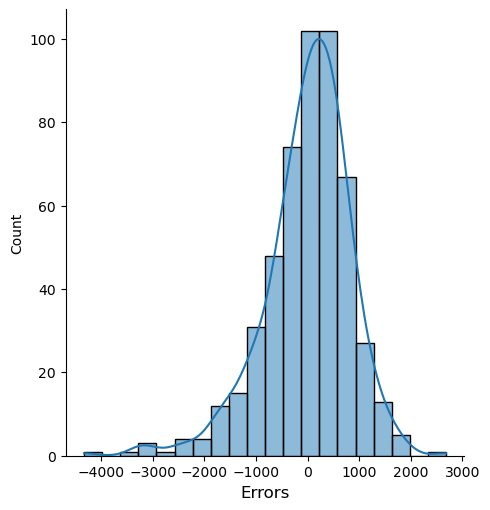

In [75]:
# Plot the histogram of the error terms on the training set
residuals = y_train - y_train_pred
fig = plt.figure(figsize = (8, 5))
sns.displot(residuals, bins = 20, kde = True)
plt.xlabel('Errors', fontsize = 12)
plt.show()

- ***The error terms follow the principle of a normal distribution curve.***

### Homoscedasticity

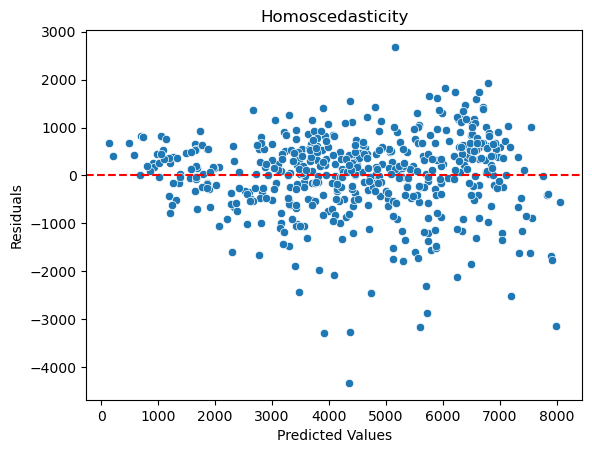

In [76]:
# Visualize Homoscedasticity
sns.scatterplot(x = y_train_pred, y = residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity')
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.show()

- ***The variance of residuals is constant across all levels of the independent variables, indicating consistent levels of variability.***

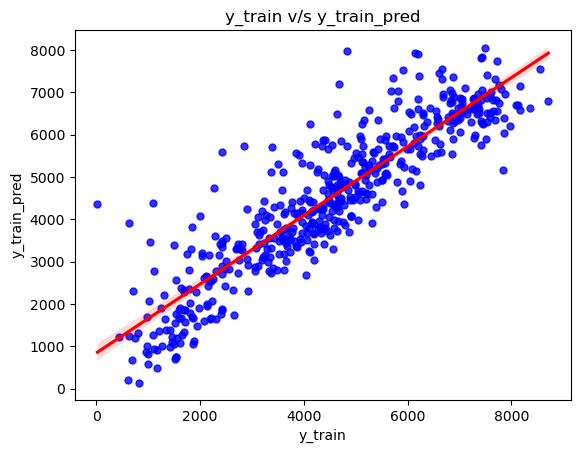

In [77]:
# Visualize the trained model using a scatter plot with a linear regression fit line
sns.regplot(x = y_train, y = y_train_pred, line_kws = { 'color': 'red' }, scatter_kws = { 's' : 25, 'color': 'blue' })

# Show the plot
plt.title('y_train v/s y_train_pred')
plt.xlabel('y_train')
plt.ylabel('y_train_pred') 
plt.show()

In [78]:
# Calculate mean squared error of the training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate RMSE
rmse_train = np.sqrt(mse_train)

print(rmse_train)

844.3702272224166


##### The linear model's assumptions hold, indicating it is well-trained and ready for testing on the test set.

### Predict Using the Final Model on the test set

In [79]:
# Retain only the selected feature from the final model
X_test_scaled = X_test_scaled[X_train_rfe_7.columns]
X_test_scaled.head()

,yr,workingday,temp,hum,windspeed,Summer,Winter,September,Sunday
184,-1.01777,-1.448092,1.306004,0.048287,-1.396242,-0.572078,-0.575091,-0.295354,-0.427633
535,0.98254,0.690564,1.614633,-0.276107,-0.986093,1.748015,-0.575091,-0.295354,-0.427633
299,-1.01777,0.690564,-0.112776,1.286864,0.078844,-0.572078,1.738857,-0.295354,-0.427633
221,-1.01777,0.690564,1.527113,-1.464546,0.110494,-0.572078,-0.575091,-0.295354,-0.427633
152,-1.01777,0.690564,1.241512,-2.307960,1.277902,1.748015,-0.575091,-0.295354,-0.427633


In [80]:
# Add constant to the test set
X_test_sm = sm.add_constant(X_test_scaled)

In [81]:
# Get the predicted values from the linear model
y_test_pred = model.predict(X_test_sm)

### Calculating $R^2$ Scores and Adjusted $R^2$ Scores for the test set

In [82]:
# Calculate R2 Score for the test set
r2_score_test = r2_score(y_true = y_test, y_pred = y_test_pred)
r2_score_test = round(r2_score_test, 2)
r2_score_test

0.8

In [83]:
# Calculate Adjusted R2 Score for the test set
adj_r2_score_test = round(adjusted_r2_score(y_test, y_test_pred, n_features = len(X_test_scaled.columns)), 2)
adj_r2_score_test

0.8

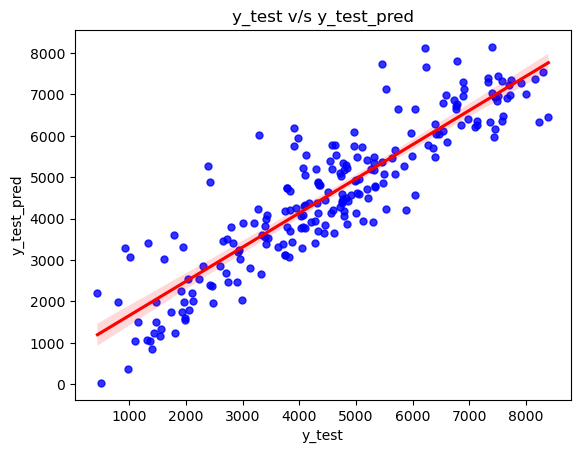

In [84]:
# Visualize the predicted model using a scatter plot with a linear regression fit line
sns.regplot(x = y_test, y = y_test_pred, line_kws = { 'color': 'red' }, scatter_kws = { 's' : 25, 'color': 'blue' })

# Show the plot
plt.title('y_test v/s y_test_pred')
plt.xlabel('y_test')
plt.ylabel('y_test_pred') 
plt.show()

In [85]:
# Calculate mean squared error of the test set
mse_test = mean_squared_error(y_test, y_test_pred)

# Calculate RMSE
rmse_test = np.sqrt(mse_test)

print(rmse_test)

839.5337851082872


In [86]:
# Coefficients of the final model
round(model.params, 2)

const         4491.30
yr             998.75
workingday     178.28
temp          1174.49
hum           -429.07
windspeed     -349.15
Summer         344.84
Winter         526.80
September      234.70
Sunday         159.98
dtype: float64

### Equation of the best fit line

In a multivariate linear regression model, the equation of the best-fit line is given by:

$Y = $$\beta_0$$ + $$\beta_1X_1$$ + $$\beta_2X_2$$ + $$\ldots$$ + $$\beta_nX_n$

- \( Y \): Dependent variable (the variable being predicted), `cnt` in this case.
- \( $\beta_0$ ): Y-intercept

- ( $\beta_1$, $\beta_2$, $\ldots$, $\beta_n$ ): Coefficients for the independent variables ( $X_1$, $X_2$, $\ldots$, $X_n$ \) respectively.

The coefficients are determined through a process that minimizes the sum of squared differences between predicted and actual values. The resulting line provides the best linear fit to the multivariate data.

For our model, the best fit line is determined by the following equation:

***cnt*** = 4491.30 + 998.75 x ***yr*** + 178.28 x ***workingday*** + 1174.49 x ***temp*** - 429.07 x ***hum*** - 349.15 x ***windspeed*** + 344.84 x ***Summer*** + 526.80 x ***Winter*** + 234.70 x ***September*** + 159.98 x ***Sunday***

### Comparing $R^2$ Scores and Adjusted $R^2$ Scores for training and test set

In [87]:
# Get R2 Score for Training set
r2_score_train = round(model.rsquared, 2)
adj_r2_score_train = round(model.rsquared_adj, 2)

# Print the R2 and Adjusted R2 scores for the training and the test set
print(f'Training Set: \tR2 - {format(r2_score_train, ".3f")}\n\t\tAdjusted R2 - {format(adj_r2_score_train, ".3f")}\n')
print(f'Test Set: \tR2 - {format(r2_score_test, ".3f")}\n\t\tAdjusted R2 - {format(adj_r2_score_test, ".3f")}')

Training Set: 	R2 - 0.810
		Adjusted R2 - 0.810

Test Set: 	R2 - 0.800
		Adjusted R2 - 0.800


- ***The close alignment of R2 and adjusted R2 values between the training and test sets (R2: 0.810 vs. 0.800 and Adjusted R2: 0.810 vs. 0.800) in a linear regression model indicates effective generalization. This similarity suggests the model avoids overfitting to the training data and is likely to perform consistently on new, unseen data.***

## Conclusion

- The equation of the best fit line is given by:
    - ***cnt*** = 4491.30 + 998.75 x ***yr*** + 178.28 x ***workingday*** + 1174.49 x ***temp*** - 429.07 x ***hum*** - 349.15 x ***windspeed*** + 344.84 x ***Summer*** + 526.80 x ***Winter*** + 234.70 x ***September*** + 159.98 x ***Sunday***
- The close alignment of R2 and adjusted R2 values between the training and test sets (R2: 0.810 vs. 0.800 and Adjusted R2: 0.810 vs. 0.800) in a linear regression model indicates effective generalization. This similarity suggests the model avoids overfitting to the training data and is likely to perform consistently on new, unseen data.
- Bike demand is influenced by features such as **yr**, **workingday**, **temp**, **hum**, **windspeed**, **Summer**, **Winter**, **September**, and **Sunday**.
- Three key feature variables, **temp**, **yr**, and **Winter**, exhibit the highest coefficient values, indicating their significant impact.
- The RMSE values of **844** in the training set and **839** in the test set for a linear regression model indicate that the model is fitting well to the training data and generalizing reasonably to new, unseen data with a small difference between training and test set performance.

## Recommendations

- **Leverage High-Impact Features:** Focus on features such as **temp**, **yr**, and **Winter** as they exhibit the highest coefficient values, indicating significant impact on bike demand.

- **Seasonal Strategies:** Develop targeted marketing and pricing strategies for different seasons, particularly emphasizing promotions during **Summer** and **Winter**.

- **Optimize Operational Planning:** Adjust bike availability and distribution based on the significant features identified, optimizing resources for peak demand periods.

- **User Engagement on Weekends:** Capitalize on increased demand on **Sunday** by introducing special promotions or events to encourage bike usage during weekends.

- **Weather-Sensitive Promotions:** Implement weather-specific promotions or incentives to encourage bike usage during favorable weather conditions, addressing the impact of **temp**, **hum**, and **windspeed**.

- **New Market Insights:** Use the developed model to gain insights into demand dynamics in the American market, informing business strategies and positioning BoomBikes competitively.

- **Continuous Monitoring and Adaptation:** Regularly update the model with new data and adapt strategies based on evolving market conditions to ensure sustained revenue growth.